<h1>Image Segmentation with PyTorch: Human Segmentation</h1>

**Aclaración**: Este notebook es resultado del proyecto guiado `Deep Learning with PyTorch: Image Segmentation` de Coursera.

**Autor**: Luis Angel Motta Valero.

Se aborda un problema de segmentación de imágenes con un dataset se imágenes de personas, empleando una red `U-Net` donde se probarán distintas arquitecturas encoder y variaciones entre los hiperparámetros para tratar de encontrar el mejor modelo de segmentación para este caso en particular en base a las pérdidas de validación.

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=fd66d98fb10a0fc3ee78c3017796ba3bad3c36489537c4b44c8d545c434cdf86
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=d389457e9a04b34f65325571a0ca12fd68224f0dffbde2bb7f5d568348109e70
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 15.47 MiB/s, done.
Resolving deltas: 100% (3/3), done.


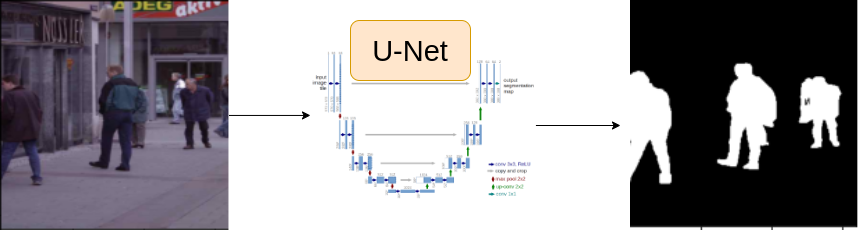

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [233]:
from json import encoder
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 30
lr = 0.0005
image_size = 320
batch_size = 16

encoder = 'timm-efficientnet-b2'
#encoder = 'resnet34'
weights = 'imagenet'

In [6]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [101]:
row = df.iloc[2]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")

Image Shape : (1055, 1280, 3)
Mask Shape : (454, 551)


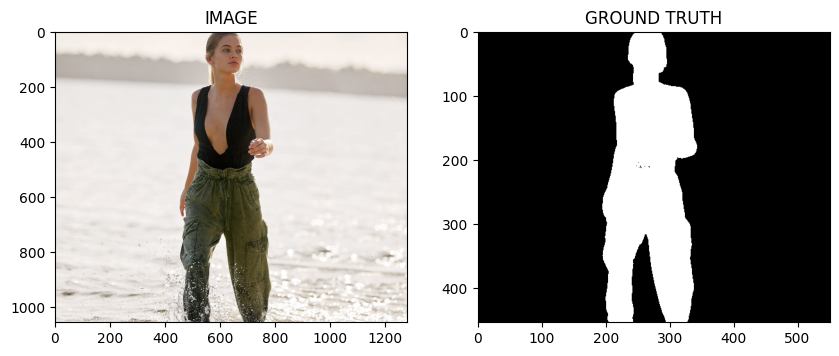

In [102]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [103]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [104]:
def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(image_size, image_size)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [62]:
from torch.utils.data import Dataset

In [105]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [106]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [107]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


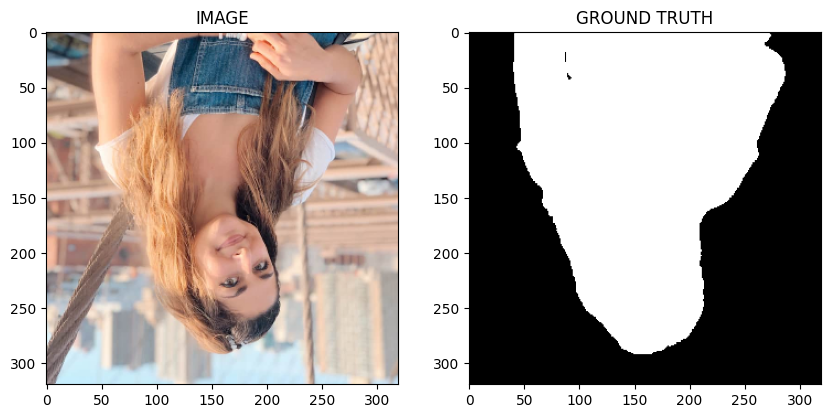

In [109]:
idx = 23
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [110]:
from torch.utils.data import DataLoader

In [111]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [112]:
print(f'total number of batches in trainloader : {len(trainloader)}')
print(f'total number of batches in validloader : {len(validloader)}')

total number of batches in trainloader : 15
total number of batches in validloader : 4


In [113]:
for images, masks in trainloader:
  break
print(f'images shape : {images.shape}')
print(f'masks shape : {masks.shape}')


images shape : torch.Size([16, 3, 320, 320])
masks shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [114]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [234]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [235]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [236]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [237]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [238]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [239]:
best_valid_loss = np.inf

for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Best model saved!')
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1}')
  print(f'Train Loss : {train_loss:.4f}')
  print(f'Valid Loss : {valid_loss:.4f}')

100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Best model saved!
Epoch : 1
Train Loss : 1.0607
Valid Loss : 0.8375


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Best model saved!
Epoch : 2
Train Loss : 0.4514
Valid Loss : 0.4142


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Best model saved!
Epoch : 3
Train Loss : 0.3151
Valid Loss : 0.2691


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Best model saved!
Epoch : 4
Train Loss : 0.2335
Valid Loss : 0.2213


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Best model saved!
Epoch : 5
Train Loss : 0.1946
Valid Loss : 0.2071


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Best model saved!
Epoch : 6
Train Loss : 0.1688
Valid Loss : 0.2007


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Best model saved!
Epoch : 7
Train Loss : 0.1736
Valid Loss : 0.1834


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


Best model saved!
Epoch : 8
Train Loss : 0.1494
Valid Loss : 0.1618


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Best model saved!
Epoch : 9
Train Loss : 0.1250
Valid Loss : 0.1507


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch : 10
Train Loss : 0.1370
Valid Loss : 0.1551


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Epoch : 11
Train Loss : 0.1280
Valid Loss : 0.1593


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 12
Train Loss : 0.1158
Valid Loss : 0.1586


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Best model saved!
Epoch : 13
Train Loss : 0.1099
Valid Loss : 0.1446


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch : 14
Train Loss : 0.0881
Valid Loss : 0.1451


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch : 15
Train Loss : 0.0950
Valid Loss : 0.1500


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Best model saved!
Epoch : 16
Train Loss : 0.0993
Valid Loss : 0.1415


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch : 17
Train Loss : 0.0886
Valid Loss : 0.1547


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 18
Train Loss : 0.0898
Valid Loss : 0.1479


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 19
Train Loss : 0.0908
Valid Loss : 0.1487


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Best model saved!
Epoch : 20
Train Loss : 0.0761
Valid Loss : 0.1393


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Best model saved!
Epoch : 21
Train Loss : 0.0791
Valid Loss : 0.1365


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Best model saved!
Epoch : 22
Train Loss : 0.0759
Valid Loss : 0.1258


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch : 23
Train Loss : 0.0685
Valid Loss : 0.1293


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch : 24
Train Loss : 0.0645
Valid Loss : 0.1279


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 25
Train Loss : 0.0646
Valid Loss : 0.1347


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch : 26
Train Loss : 0.0609
Valid Loss : 0.1306


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch : 27
Train Loss : 0.0616
Valid Loss : 0.1286


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 28
Train Loss : 0.0607
Valid Loss : 0.1266


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch : 29
Train Loss : 0.0584
Valid Loss : 0.1310


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

Epoch : 30
Train Loss : 0.0648
Valid Loss : 0.1611


# Task 9 : Inference

In [252]:
idx = 18

model.load_state_dict(torch.load('/content/best_model.pt', weights_only=True))
image, mask = validset[idx]
logits_mask = model(image.to(device).unsqueeze(0)) #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

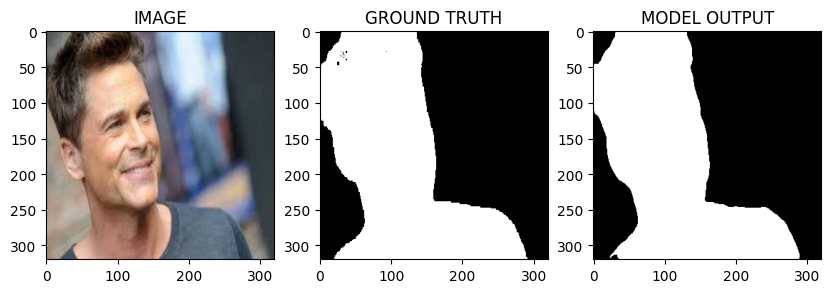

In [253]:
pred_mask = pred_mask.detach().cpu().squeeze(0) # redimensionar (1, c, h, w) -> (c, h, w)
helper.show_image(image, mask, pred_mask)

## Conclusión
<p>Luego de haber entrenado el modelo empleando diversas variaciones de hiperparámetros, tales como el learning rate (lr), el batch size y el modelo encoder, se obtuvo los siguientes resultados en cuanto a las pérdidas de entrenamiento y validación.

In [261]:
import pandas as pd

data = {
    "Model": ["resnet34", "timm-efficientnet-b0", "timm-efficientnet-b0", "timm-efficientnet-b2", "timm-efficientnet-b0", "timm-efficientnet-b2"],
    "learning_rate": [0.002, 0.002, 0.002, 0.005, 0.005, 0.0005],
    "batch_size": [16, 16, 32, 16, 16, 16],
    "train_loss": [0.25, 0.10, 0.15, 0.09, 0.13, 0.07],
    "val_loss": [0.34, 0.19, 0.20, 0.15, 0.16, 0.12]
}

df = pd.DataFrame(data)
df['difference'] = df['val_loss'] - df['train_loss']

# Convertir la tabla a Markdown
table_md = df.to_markdown(index=False)

# Imprimir la tabla en Markdown
print(table_md)

| Model                |   learning_rate |   batch_size |   train_loss |   val_loss |   difference |
|:---------------------|----------------:|-------------:|-------------:|-----------:|-------------:|
| resnet34             |          0.002  |           16 |         0.25 |       0.34 |         0.09 |
| timm-efficientnet-b0 |          0.002  |           16 |         0.1  |       0.19 |         0.09 |
| timm-efficientnet-b0 |          0.002  |           32 |         0.15 |       0.2  |         0.05 |
| timm-efficientnet-b2 |          0.005  |           16 |         0.09 |       0.15 |         0.06 |
| timm-efficientnet-b0 |          0.005  |           16 |         0.13 |       0.16 |         0.03 |
| timm-efficientnet-b2 |          0.0005 |           16 |         0.07 |       0.12 |         0.05 |


Considerando los resultados en relación a las pérdidas de validación (parámetro que determinó el mejor modelo), así como su diferencia con las pérdidas de entrenamiento (grado de overfitting), se deja la última combinación realizada como la definitiva para este caso. Adicionalmente, se probó en inferencia cada modelo resultante y, con ello, se verificó que fue la elección correcta.

<a href='https://drive.google.com/file/d/1z74g0ZygiVFnsFG34kOGnqGj84mlJ87r/view?usp=drive_link'>Mejor modelo</a>:

**Model**: timm-efficientnet-b2<br>
**Learning rate**: 0.0005<br>
**Batch size**: 16

In [262]:
# Guarda el mejor modelo en la cuenta de Drive
from google.colab import drive
drive.mount('/content/drive')
!cp /content/best_model.pt /content/drive/MyDrive/

Mounted at /content/drive


In [ ]:
# Descarga el archivo con el mejor modelo en local
from google.colab import files
files.download('/content/best_model.pt')

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya